# Investigate alleles that increased abundance

Almost all variants with abundance changes that surpass assay variability are decreases in abundance. For the very few cases that increased abundance, we want to see if there is anything biologically interesting going on here.

In [1]:
import polars as pl
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
sys.path.append("../..")
from utils import *

In [2]:
outputs_dir = "../3_outputs"

## 1. Variants with increased abundance

In [3]:
scores = pl.read_csv(f"{outputs_dir}/annotated_perturbation_scores.csv", infer_schema_length=1000000)
incr_abun = scores.filter(pl.col("zscore_log2") > 1.96)
print(incr_abun.select(['symbol', 'aa_change', 'zscore_log2', 'clinvar_clnsig_clean', 'StarStatus']))

shape: (15, 5)
┌────────┬───────────┬─────────────┬──────────────────────┬────────────┐
│ symbol ┆ aa_change ┆ zscore_log2 ┆ clinvar_clnsig_clean ┆ StarStatus │
│ ---    ┆ ---       ┆ ---         ┆ ---                  ┆ ---        │
│ str    ┆ str       ┆ f64         ┆ str                  ┆ i64        │
╞════════╪═══════════╪═════════════╪══════════════════════╪════════════╡
│ SH3BP2 ┆ Gly420Arg ┆ 2.593702    ┆ 1_Pathogenic         ┆ null       │
│ MID1   ┆ Pro151Leu ┆ 3.206029    ┆ 4_VUS                ┆ 1          │
│ KLHL3  ┆ Glu85Ala  ┆ 3.818985    ┆ 1_Pathogenic         ┆ null       │
│ KLHL3  ┆ Ala77Glu  ┆ 3.717149    ┆ 1_Pathogenic         ┆ null       │
│ ALAS2  ┆ Ile439Asn ┆ 2.010533    ┆ 1_Pathogenic         ┆ null       │
│ …      ┆ …         ┆ …           ┆ …                    ┆ …          │
│ KLHL3  ┆ Cys164Phe ┆ 4.37136     ┆ 1_Pathogenic         ┆ null       │
│ TPM1   ┆ Glu23Gln  ┆ 2.761697    ┆ 4_VUS                ┆ 1          │
│ PLA2G6 ┆ Thr585Ile ┆ 2.342282    ┆

In [4]:
scores.filter(pl.col("symbol")=="RAD51D")

symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,…,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,abund_zscore
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool,bool,f64,f64
"""RAD51D""","""698A>G""","""Glu233Gly""","""RAD51D_Glu233Gly""",732.550049,2467.5,0.26,0.174343,1.491312,0.88984,0.0,1.286316,"""ENSG00000185379""","""CCSBVarC001140""","""ALE00001140""","""NC_000017.11:35103294:T:C""","""RC4""","""RC4_Mut_GDEh1002""","""C07""","""GDEhDisVCh_40046""","""H04""","""2""","""RC4_Mut_GDDh1002""","""C07""","""NULL""","""NULL""","""VUSMutpDEST2_06""","""F01""","""VUSmut_GDEh12""","""G05""",1,2,1,1,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""RAD51D_Glu233Gly""","""Glu233Gly""",true,false,true,-2.884438,1.286316
"""RAD51D""","""494G>A""","""Arg165Gln""","""RAD51D_Arg165Gln""",683.410034,2918.299927,0.227091,0.174343,1.302554,0.504036,0.0,0.854027,"""ENSG00000185379""","""CCSBVarC002917""","""ALE00002917""","""NC_000017.11:35106468:C:T""","""RC4""","""NatVar_GDE_001""","""F05""","""GDEhDisVCh_40046""","""E03""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""VUSMutpDEST2_06""","""G01""","""VUSmut_GDEh12""","""E02""",1,1,0,null,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,true,-2.884438,0.854027


## 2. Group the variants by gene

In [5]:
symbol_medians = scores.filter(~pl.col("zscore_log2").is_null()).group_by("symbol").agg(
    pl.col("zscore_log2").median().alias("median_log2")
).sort("median_log2")

symbol_order = symbol_medians.select('symbol').to_series().to_list()
scores_plot = scores.join(symbol_medians, on="symbol").to_pandas()
scores_plot['symbol'] = pd.Categorical(scores_plot['symbol'], categories=symbol_order, ordered=True)
scores_plot

,symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,...,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,abund_zscore,median_log2
0,KCNJ2,899G>A,Gly300Asp,KCNJ2_Gly300Asp,693.679993,5069.049805,0.133067,0.841771,0.158080,-1.835174,...,None,None,None,None,None,True,True,-2.884438,-5.882805,-5.859161
1,HBD,174C>A,Asn58Lys,HBD_Asn58Lys,33.840000,2474.280029,0.012192,0.077713,0.156882,-1.837623,...,None,None,None,None,None,True,True,-2.884438,-5.907103,-5.834380
2,SMAD3,376C>T,His126Tyr,SMAD3_His126Tyr,993.600037,3757.339966,0.267095,1.033889,0.258340,-1.630252,...,None,None,None,None,None,True,True,-2.884438,-4.313822,-0.819028
3,HBD,110C>A,Pro37His,HBD_Pro37His,31.959999,3535.250000,0.008351,0.077713,0.107457,-1.938643,...,None,None,None,None,None,True,True,-2.884438,-7.115858,-5.834380
4,KRT2,558C>A,Asn186Lys,KRT2_Asn186Lys,214.760010,2279.899902,0.095686,0.304336,0.314409,-1.515652,...,None,None,None,None,None,True,True,-2.884438,-3.686394,-3.230985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,SMAD3,335C>T,Ala112Val,SMAD3_Ala112Val,963.700012,2708.780029,0.357096,1.033889,0.345391,-1.452326,...,None,None,None,None,None,True,True,-2.884438,-3.396248,-0.819028
737,GCK,131G>A,Gly44Asp,GCK_Gly44Asp,2746.079956,2448.382416,1.085445,1.730655,0.660002,-0.809289,...,None,None,None,None,None,False,True,-2.884438,-1.357472,-1.953208
738,PKP2,1114G>C,Ala372Pro,PKP2_Ala372Pro,1100.090027,1425.280029,0.698059,0.629182,1.109471,0.109389,...,None,None,None,None,None,False,True,-2.884438,0.329630,-0.061359
739,STXBP1,539G>A,Cys180Tyr,STXBP1_Cys180Tyr,612.869995,2037.875000,0.289300,1.265654,0.228578,-1.691083,...,None,None,None,None,None,True,True,-2.884438,-4.768856,-4.714443


<Figure size 640x480 with 0 Axes>

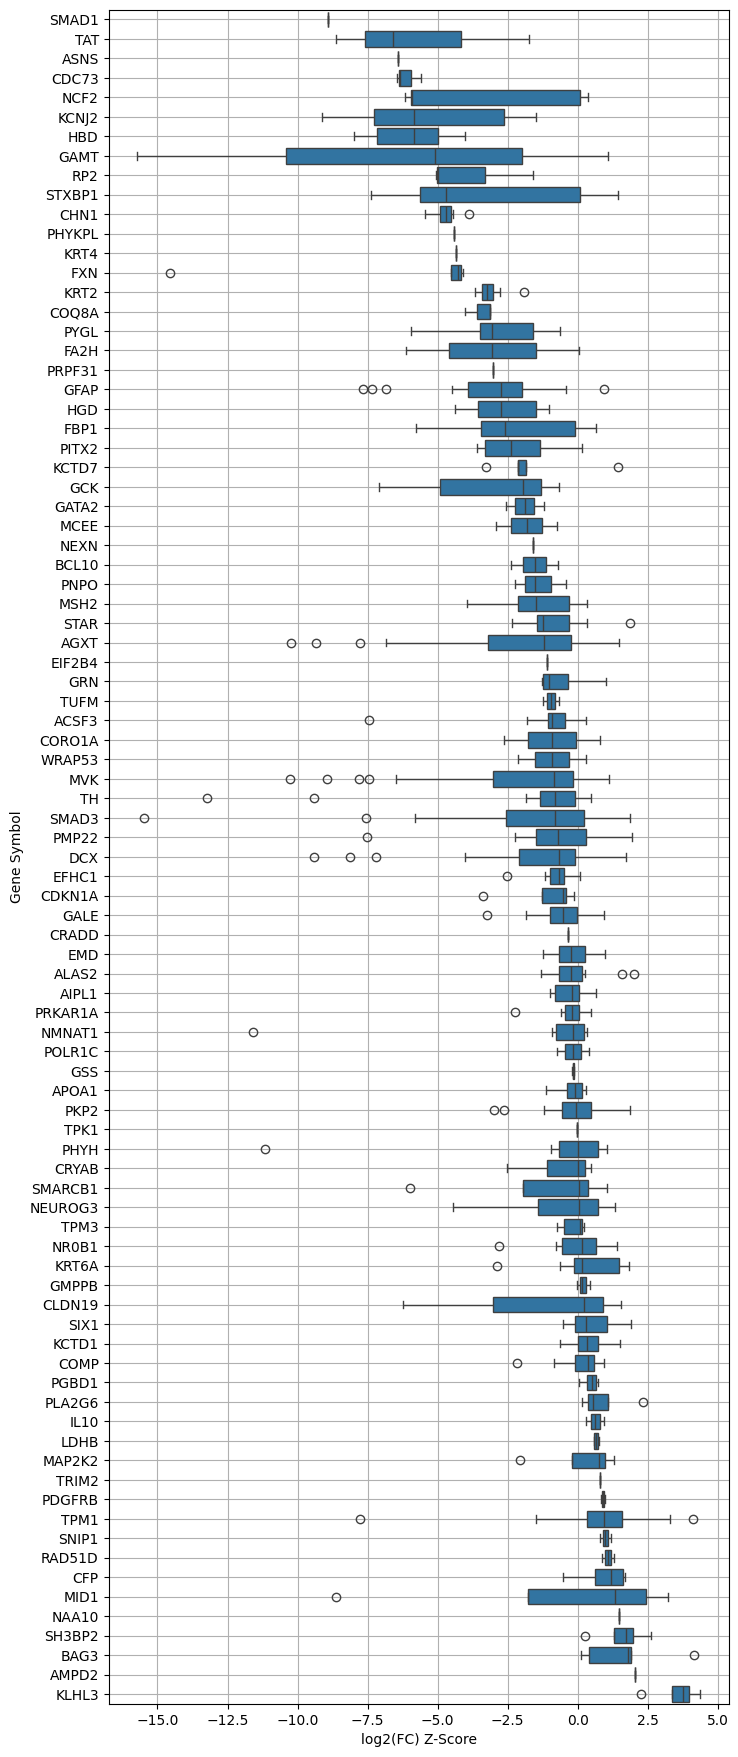

In [6]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 22))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", ax=ax)
ax.set_xlabel("log2(FC) Z-Score")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

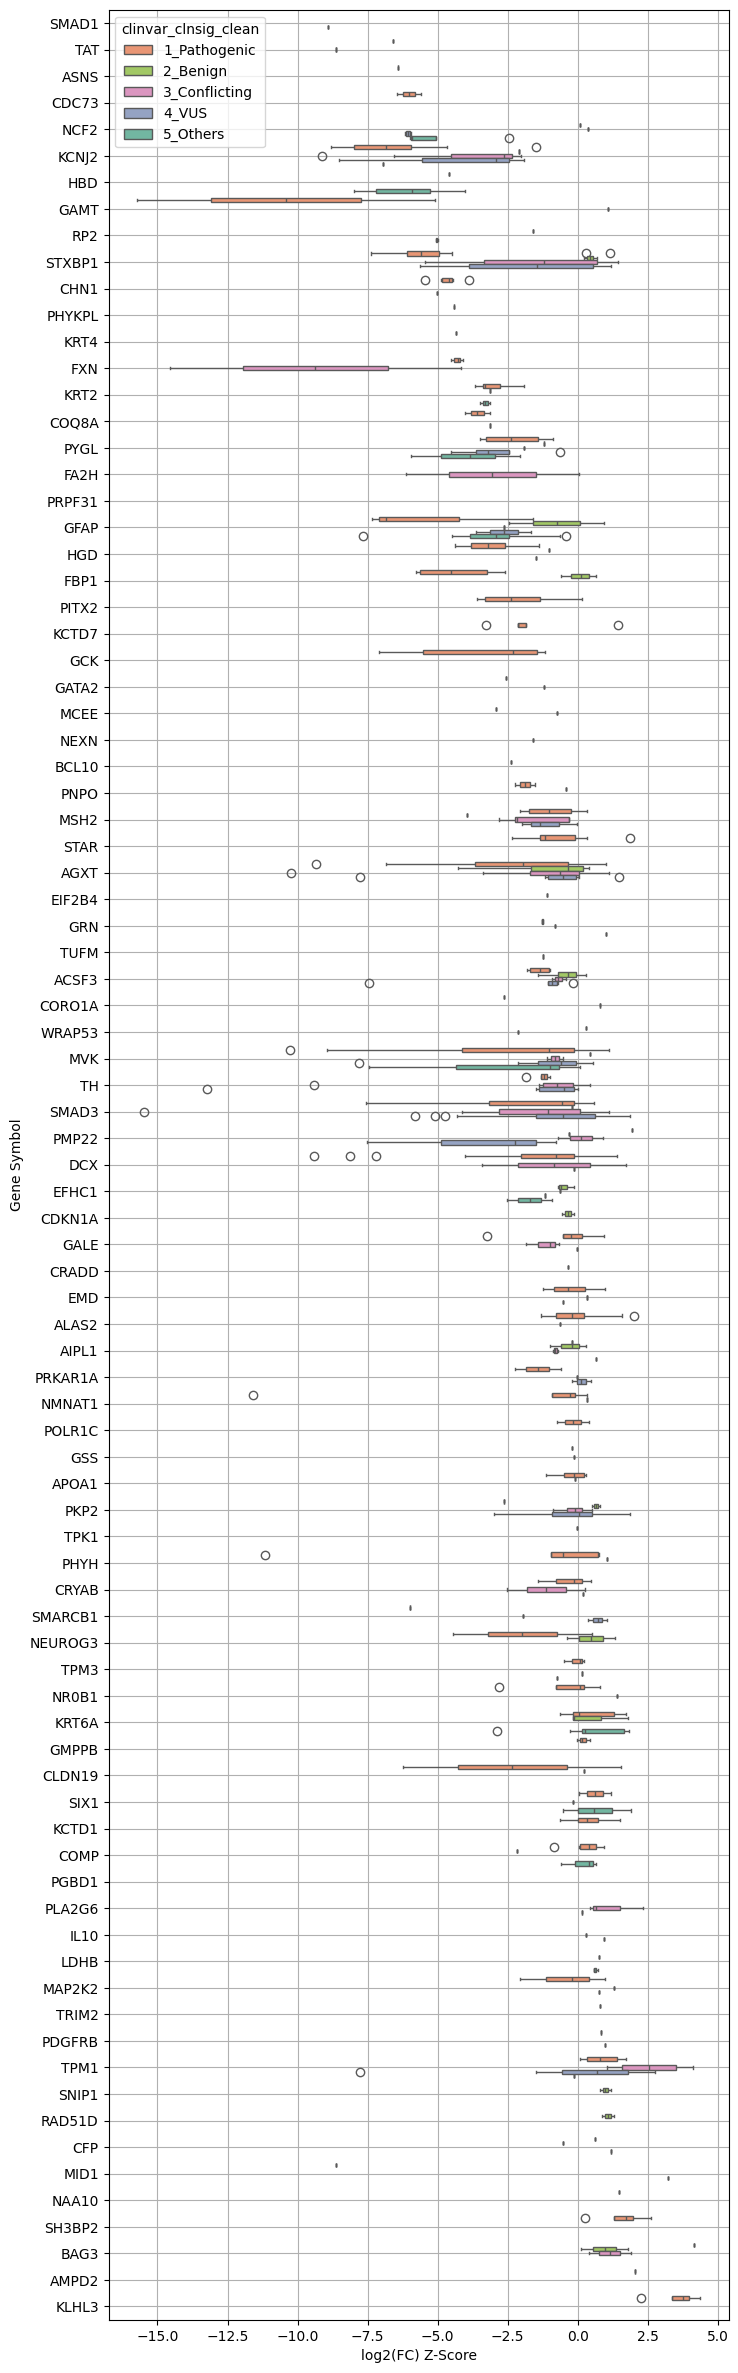

In [7]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 30))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", 
            palette=palette_dict["clinvar_clnsig_clean"], ax=ax, 
            hue="clinvar_clnsig_clean", 
            hue_order=sorted(scores_plot.dropna(subset="clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
           )
ax.set_xlabel("log2(FC) Z-Score")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

## 3. Map with Pillar Project

In [8]:
def plot_gene_level_summary(df, hit_col, cell_change, hits_only=True, null_only=False, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort(["pct_hits", "len"], descending=False)
    )

    if hits_only:
        total_allele_hit_sum_df = total_allele_hit_sum_df.filter(
            pl.col("pct_hits") > 0
        ).to_pandas()
    elif null_only:
        total_allele_hit_sum_df = total_allele_hit_sum_df.filter(
            pl.col("pct_hits") == 0
        ).to_pandas()
    else:
        total_allele_hit_sum_df = total_allele_hit_sum_df.to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.6
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.1,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=9 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=9 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max()+10)
    ax.set_ylim(-0.5, len(y) + -.3)
    ax.legend(fontsize=11, loc="lower right")

<Figure size 640x480 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

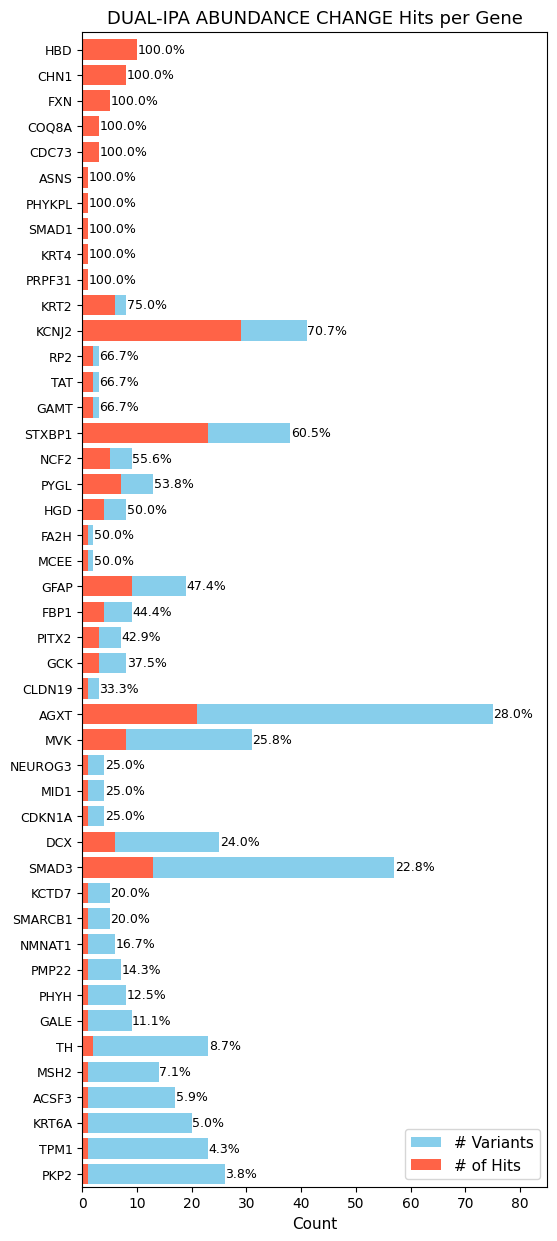

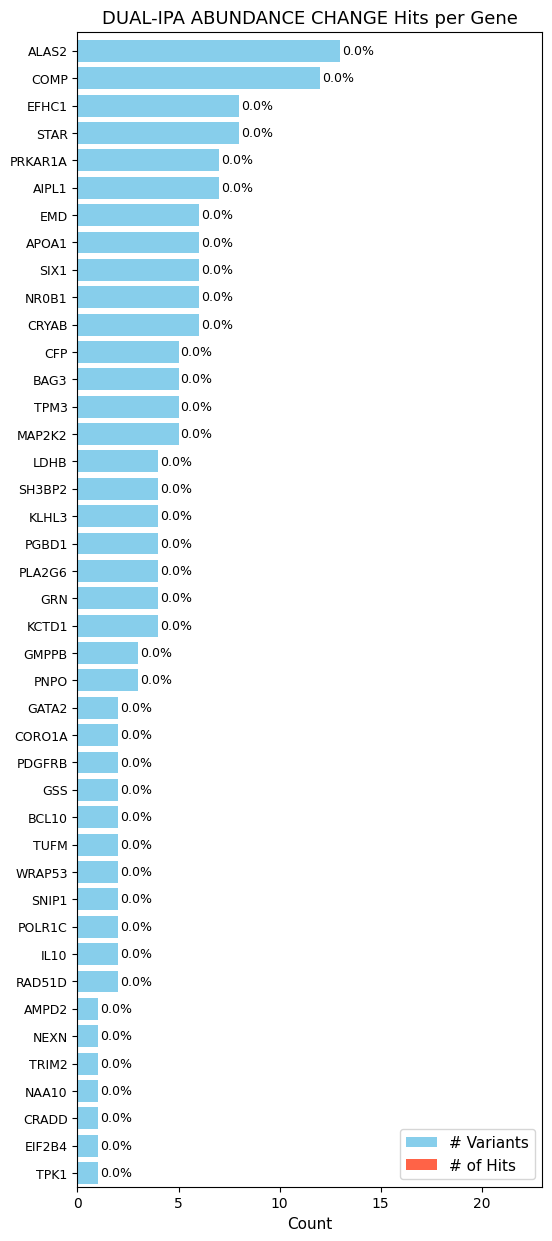

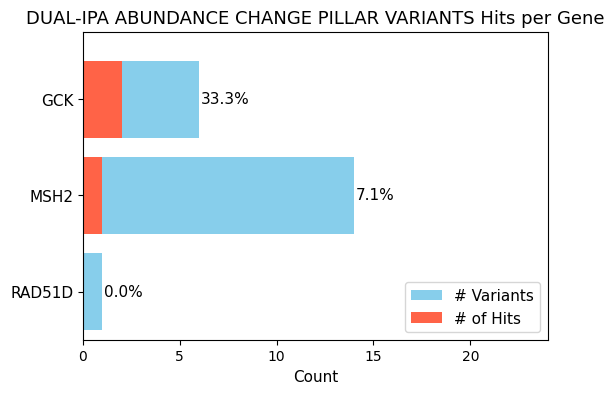

In [10]:
scores = scores.with_columns(pl.col("symbol").alias("Gene"))
func_scores = scores.filter(pl.col("pillar_tested"))

plt.clf()
fig, ax = plt.subplots(1,1,figsize=(6,15))
plot_gene_level_summary(scores, "dualipa_abund_change", "DUAL-IPA Abundance Change", ax=ax)
fig, ax = plt.subplots(1,1,figsize=(6,15))
plot_gene_level_summary(scores, "dualipa_abund_change", "DUAL-IPA Abundance Change", hits_only=False, null_only=True, ax=ax)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plot_gene_level_summary(func_scores, "dualipa_abund_change", "DUAL-IPA Abundance Change Pillar Variants", hits_only=False, ax=ax)
plt.show()

<ipython-input-14-2532764ea26e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.flatten()[i-1].set_xticklabels(axes.flatten()[i-1].get_xticklabels(), rotation=10)


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 MaveDB class,zscore_log2
str,str,str,str,f64
"""MSH2_Leu92Val""","""MSH2_Leu92Val""","""3_Conflicting""","""Abnormal""",-0.310709
"""MSH2_Ala305Thr""","""MSH2_Ala305Thr""","""3_Conflicting""","""Abnormal""",-2.803915
"""MSH2_Leu687Pro""","""MSH2_Leu687Pro""","""1_Pathogenic""","""Abnormal""",-1.62861
"""GCK_Met381Arg""","""GCK_Met381Arg""","""1_Pathogenic""","""Abnormal""",-2.326245
"""MSH2_Leu440Pro""","""MSH2_Leu440Pro""","""1_Pathogenic""","""Abnormal""",0.326193
"""MSH2_Arg96His""","""MSH2_Arg96His""","""2_Benign""","""Abnormal""",-3.96477
"""GCK_Glu236Lys""","""GCK_Glu236""","""1_Pathogenic""","""Abnormal""",-6.757914
"""GCK_Gly178Arg""","""GCK_Gly178""",null,"""Abnormal""",-0.686217
"""MSH2_Leu421Pro""","""MSH2_Leu421Pro""","""4_VUS""","""Abnormal""",-0.021206


<ipython-input-14-2532764ea26e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.flatten()[i-1].set_xticklabels(axes.flatten()[i-1].get_xticklabels(), rotation=10)


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 MaveDB class,zscore_log2
str,str,str,str,f64
"""MSH2_Gly40Ser""","""MSH2_Gly40Ser""","""3_Conflicting""","""Normal""",-0.312483
"""MSH2_Arg96His""","""MSH2_Arg96His""","""2_Benign""","""Normal""",-3.96477
"""MSH2_Glu562Val""","""MSH2_Glu562Val""","""3_Conflicting""","""Normal""",-2.224665
"""MSH2_Arg524Pro""","""MSH2_Arg524Pro""","""1_Pathogenic""","""Normal""",-0.454283
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Not specified""",-4.287583
"""MSH2_Ala714Val""","""MSH2_Ala714Val""","""3_Conflicting""","""Normal""",-2.156276
"""MSH2_Leu341Pro""","""MSH2_Leu341Pro""","""1_Pathogenic""","""Normal""",-2.051809
"""MSH2_Leu421Pro""","""MSH2_Leu421Pro""","""4_VUS""","""Normal""",-0.021206
"""MSH2_Thr335Ile""","""MSH2_Thr335Ile""","""4_VUS""","""Normal""",-1.342705


<ipython-input-14-2532764ea26e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.flatten()[i-1].set_xticklabels(axes.flatten()[i-1].get_xticklabels(), rotation=10)


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 MaveDB class,zscore_log2
str,str,str,str,f64
"""GCK_Gly178Arg""","""GCK_Gly178""",null,"""Abnormal""",-0.686217
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Abnormal""",-4.287583


<Figure size 640x480 with 0 Axes>

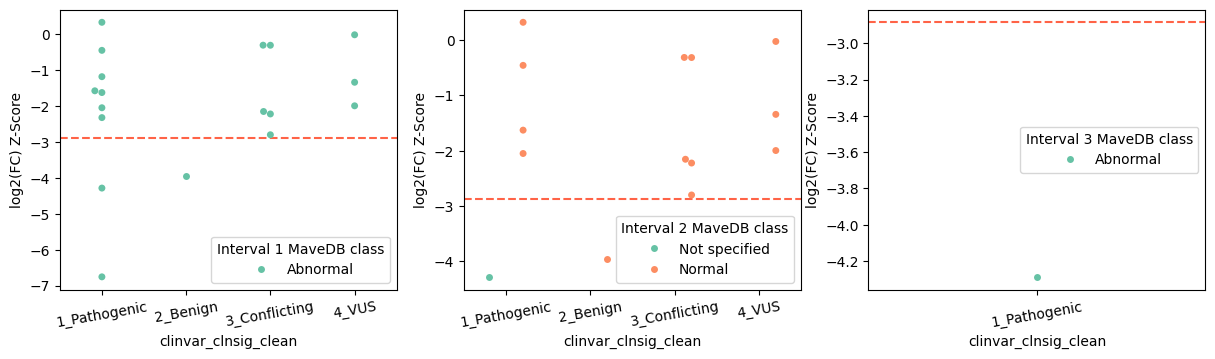

In [14]:
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

plt.clf()
fig, axes = plt.subplots(2, 4, figsize=(20,8))
for i in range(1,7):
    # int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
    if func_mave.shape[0] > 0:
        # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
        # fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
        sns.swarmplot(
            data=func_mave.unique(subset="gene_variant").to_pandas(),
            x="clinvar_clnsig_clean",
            y="zscore_log2",
            ax=axes.flatten()[i-1],
            palette="Set2", #palette_dict["clinvar_clnsig_clean"], 
            hue=mavedb_name, 
            order=hue_order,
            # hue_order=hue_order,
            dodge="auto",
            # width=.6,
            # gap=.2
        )
        axes.flatten()[i-1].set_ylabel("log2(FC) Z-Score")
        axes.flatten()[i-1].set_xticklabels(axes.flatten()[i-1].get_xticklabels(), rotation=10)
        display(func_mave.unique(subset="gene_variant").select(
            ["gene_variant", "gene_variant_pp","clinvar_clnsig_clean", mavedb_name, "zscore_log2"]
        ))
        axes.flatten()[i-1].axhline(func_mave["dualipa_threshold"].to_numpy()[0], color="tomato", linestyle="--")
        # sns.boxenplot(
        #     data=func_mave.unique(subset="gene_variant").to_pandas(),
        #     x=mavedb_name,
        #     y="zscore_log2",
        #     ax=ax[1],
        #     palette=palette_dict["clinvar_clnsig_clean"],
        #     hue="clinvar_clnsig_clean", 
        #     hue_order=hue_order,
        #     dodge=True
        # )
    else:
        fig.delaxes(axes.flatten()[i-1])

fig.delaxes(axes.flatten()[6])
fig.delaxes(axes.flatten()[7])
plt.subplots_adjust(wspace=0.2)
plt.show()